In [162]:
%pylab inline
import pickle as pk
import numpy as np
from glob import glob
from pydiffmap import diffusion_map as dm

def plot_patches(data,h=40,w=15,_titles=[]):
    figure(figsize=(w*2,h*2))
    for i in range(h*w):
        if i>=data.shape[0]:
            break
        subplot(h,w,i+1);
        pic=data[i,:,:]
        #P=convolve(pic,gaussian)/factor

        fig=imshow(pic,cmap='gray')
        if(len(_titles)>i):
            plt.title(_titles[i])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
#plot_patches(scombined,h=2,_titles=[str(i) for i in range(scombined.shape[0])])

def pack_pics(Reps):
    size=Reps[0].shape[0]
    _len=len(Reps)
    Reps_mat=np.zeros([_len,size,size])
    for i in range(_len):
        Reps_mat[i,:,:]=Reps[i]
    return Reps_mat

def dist2(a,b):
    diff=(a-b)**2
    return sum(diff.flatten())

def scatter_pics(Reps,Reps_count,dmap,i1,i2,canvas_size=[500,500],_title='(100,1)'):
    image_size=np.array(Reps[0].shape)
    canvas_size=np.array(canvas_size)

    _minx=min(dmap[:,i1])
    _maxx=max(dmap[:,i1])
    _miny=min(dmap[:,i2])
    _maxy=max(dmap[:,i2])

    shift_x = -_minx
    scale_x = canvas_size[0]/(_maxx - _minx)
    shift_y = -_miny
    scale_y = canvas_size[1]/(_maxy - _miny)

    x=[int((_x+shift_x)*scale_x) for _x in dmap[:,i1]]
    y=[int((_y+shift_y)*scale_y) for _y in dmap[:,i2]]

    canvas=2*np.ones(canvas_size+image_size)
    for i in range(len(Reps)):
        if(Reps_count[i]>0):
            canvas[x[i]:x[i]+image_size[0],y[i]:y[i]+image_size[1]]=Reps[i]

    figure(figsize=[40,40])
    imshow(canvas,cmap='gray')
    ylabel('eigen-vector %d'%(i1+1),fontsize=40)
    xlabel('eigen-vector %d'%(i2+1),fontsize=40)
    title(_title,fontsize=40)
    
def embedding_plot(dmap_instance, dim=2,
                   d1=0,d2=1,d3=2, scatter_kwargs=None, show=True):
    """
    Creates diffusion map embedding scatterplot. By default, the first two diffusion
    coordinates are plotted against each other.

    Parameters
    ----------
    dmap_instance : DiffusionMap Instance
        An instance of the DiffusionMap class.
    dim: int, optional, 2 or 3.
        Optional argument that controls if a two- or three dimensional plot is produced.
    d1,d2,d3: the 2 or 3 eigenvectors to plot
    scatter_kwargs : dict, optional
        Optional arguments to be passed to the scatter plot, e.g. point color,
        point size, colormap, etc.
    show : boolean, optional
        If true, calls plt.show()

    Returns
    -------
    fig : pyplot figure object
        Figure object where everything is plotted on.

    Examples
    --------
    # Plots the top two diffusion coords, colored by the first coord.
    >>> scatter_kwargs = {'s': 2, 'c': mydmap.dmap[:,0], 'cmap': 'viridis'}
    >>> embedding_plot(mydmap, scatter_kwargs)

    """
    if scatter_kwargs is None:
        scatter_kwargs = {}
    fig = plt.figure(figsize=(6, 6))
    if (dim == 2):
        plt.scatter(dmap_instance.dmap[:, d1], dmap_instance.dmap[:, d2], **scatter_kwargs)
        plt.title('Embedding given by first two DCs.')
        plt.xlabel(r'$\psi_1$')
        plt.ylabel(r'$\psi_2$')
    elif (dim == 3):
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(dmap_instance.dmap[:, d1], dmap_instance.dmap[:, d2], dmap_instance.dmap[:, d3], **scatter_kwargs)
        ax.set_title('Embedding given by first three DCs.')
        ax.set_xlabel(r'$\psi_1$')
        ax.set_ylabel(r'$\psi_2$')
        ax.set_zlabel(r'$\psi_3$')
    plt.axis('tight')
    if show:
        plt.show()
    return fig


Populating the interactive namespace from numpy and matplotlib


## Calculate laplacian random-walk matrix

The matrix corresponds to a simple random walk on the individual examples  where the location of each example is replaced by the location of the corresponding representative. 

We use [pydiffmap](https://pydiffmap.readthedocs.io/en/master/)

In [167]:
import pickle
VQ=pickle.load(open('VQ4.pkl','rb'))
VQ.keys()

dict_keys([(10, 1), (10, 0), (500, 0), (500, 1), (100, 1), (100, 0)])

In [185]:
new_Reps,Reps_count=VQ[(500,1)]
_size=21

L=len(new_Reps)
new_Reps[0].shape
data1D=np.concatenate([x.reshape([1,_size**2]) for x in new_Reps])
data1D.shape

(468, 441)

Text(0.5,1,'distances between centroids')

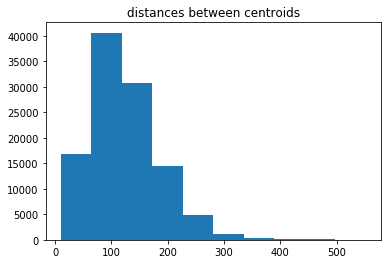

In [186]:
dists=[]
for i in range(L):
    for j in range(i):
        dists.append(dist2(new_Reps[i],new_Reps[j]))
hist(dists);
title('distances between centroids')

In [187]:
data1D.shape,len(Reps_count)

((468, 441), 468)

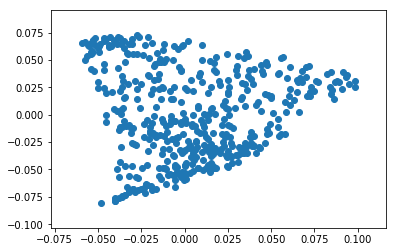

In [188]:
# initialize Diffusion map object.

neighbor_params = {'n_jobs': -1, 'algorithm': 'ball_tree'}

mydmap = dm.DiffusionMap(n_evecs=10, k=60, epsilon=50.0, alpha=1.0, neighbor_params=neighbor_params)
# fit to data and return the diffusion map.
mydmap.fit(data1D,weights=Reps_count)
dmap=mydmap.transform(data1D)
#%pylab inline
pylab.scatter(dmap[:,2],dmap[:,1]);

Text(0.5,1,'no. of examples per partition')

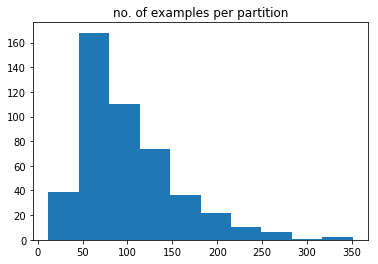

In [189]:
hist(Reps_count);
title('no. of examples per partition')

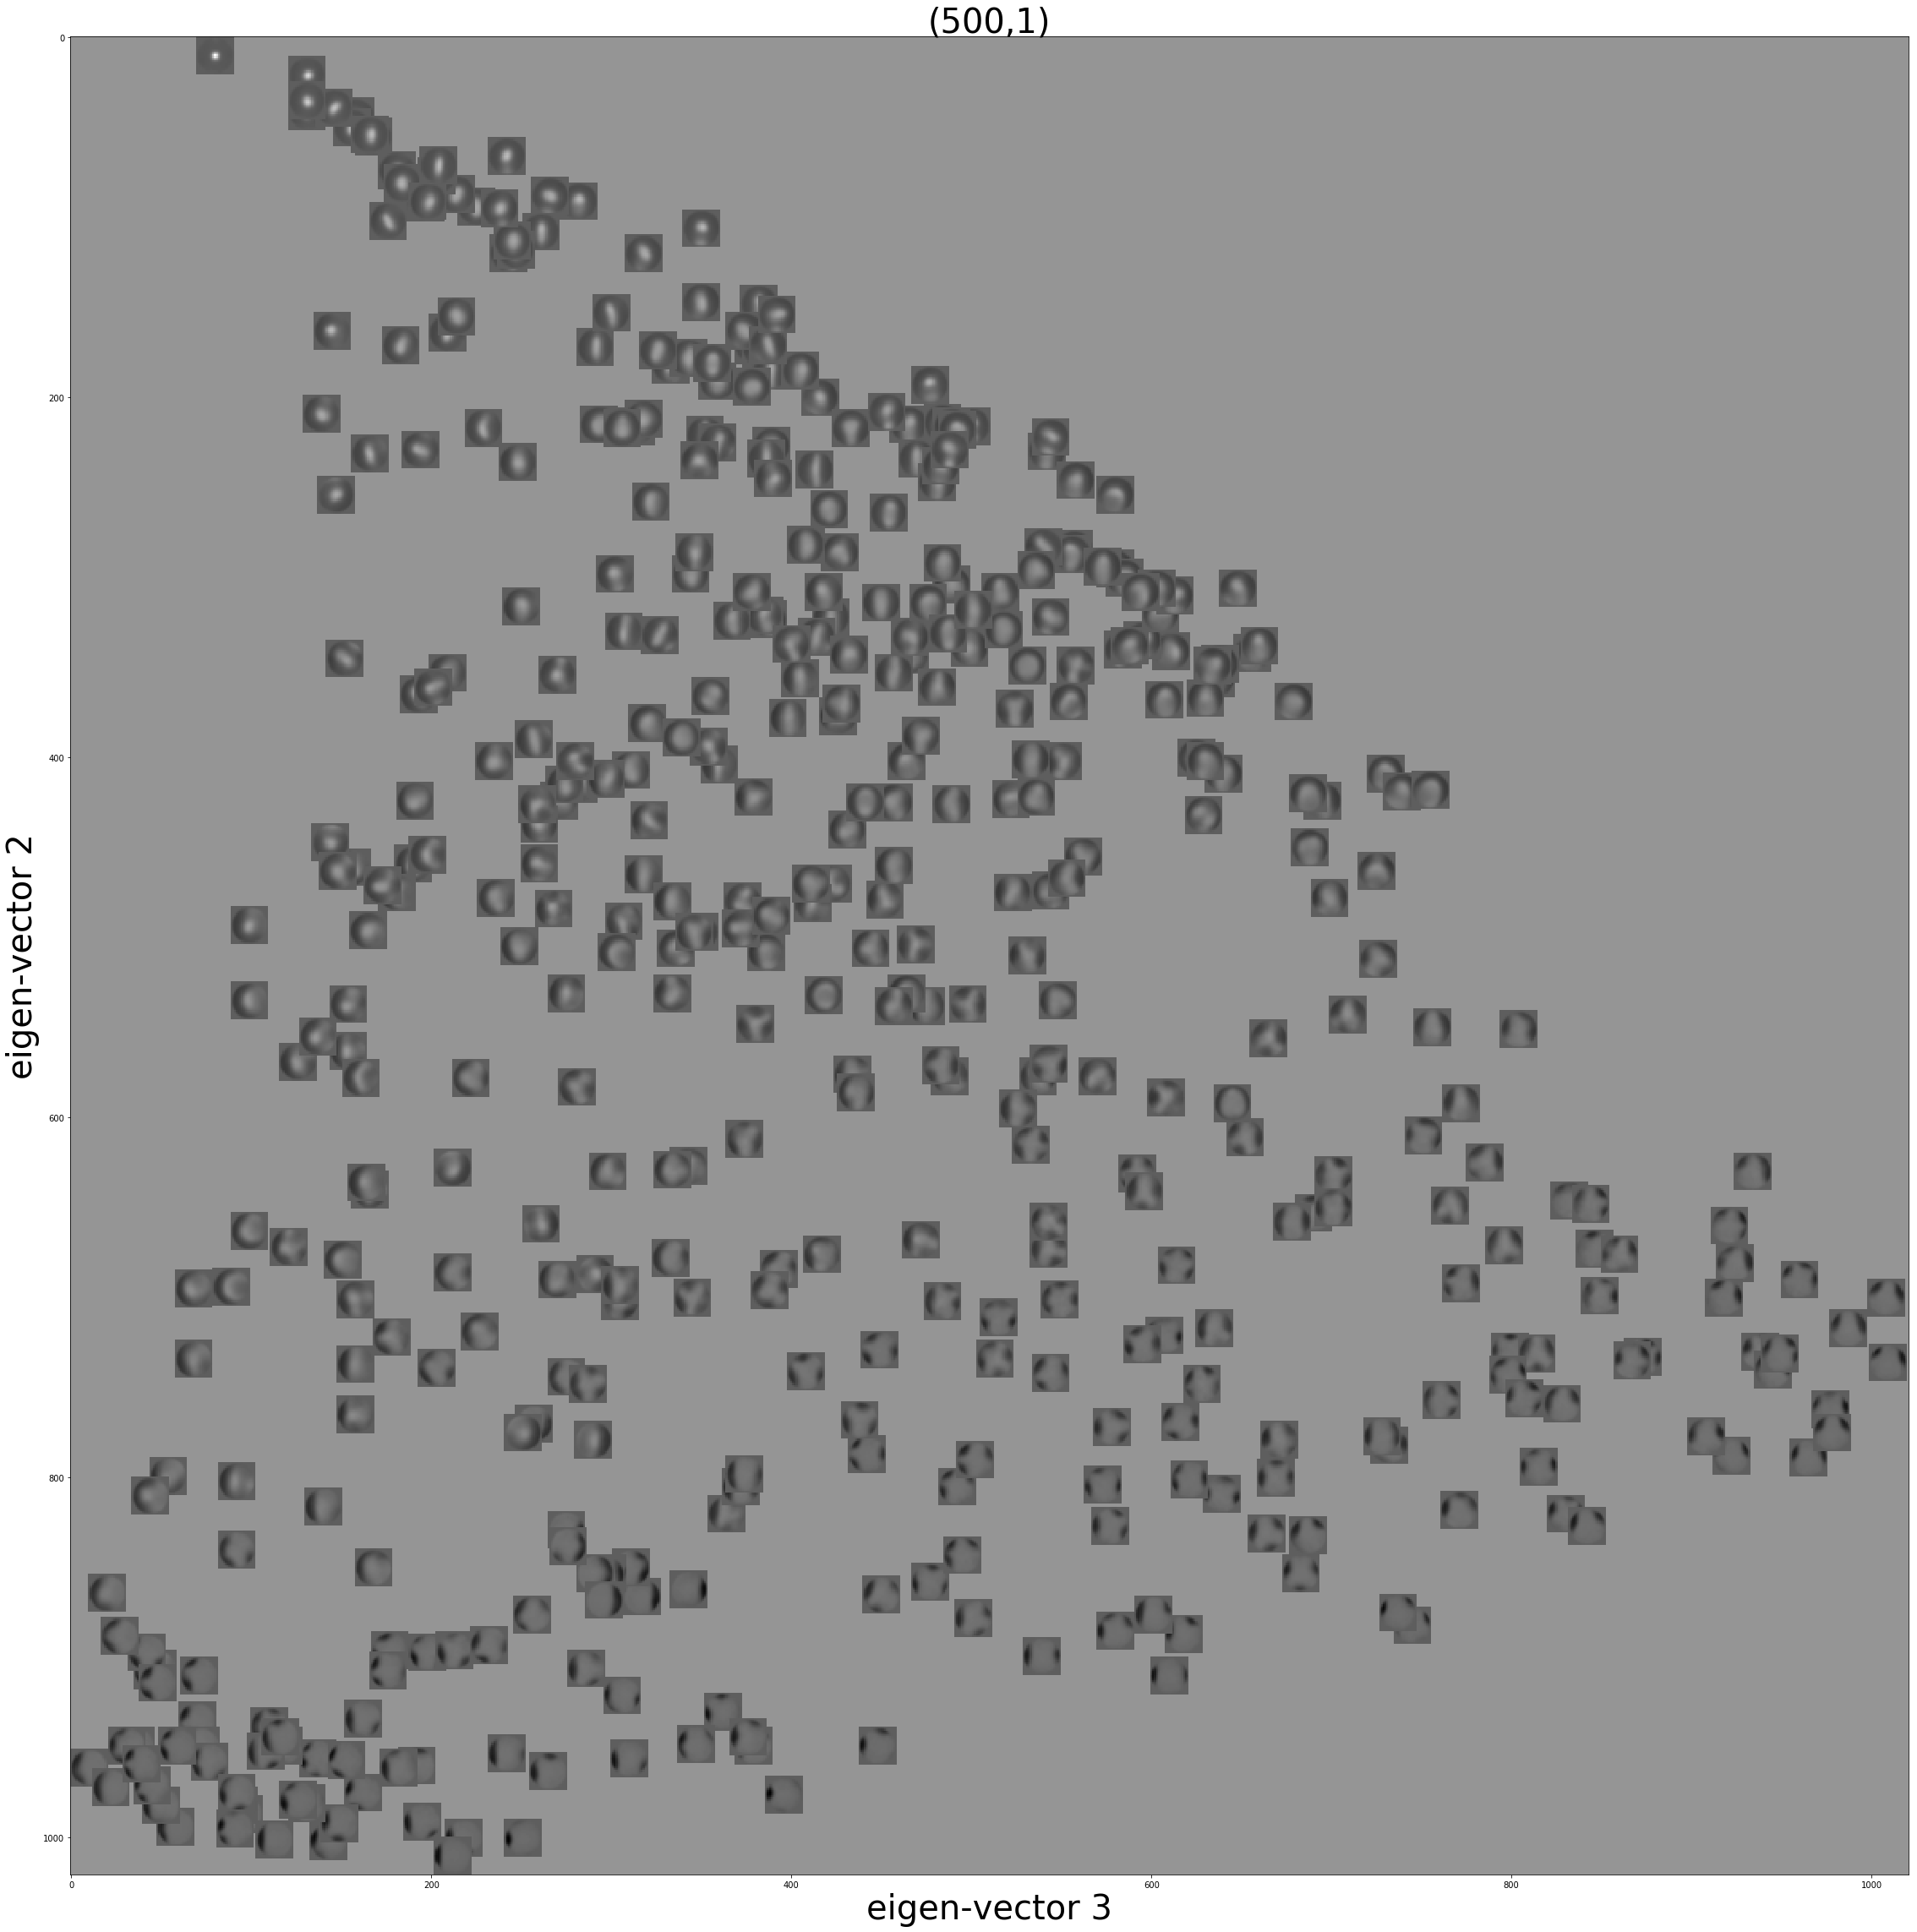

In [190]:
scatter_pics(new_Reps,Reps_count,dmap,1,2,canvas_size=[1000,1000],_title='(500,1)')

<Figure size 1440x1440 with 0 Axes>

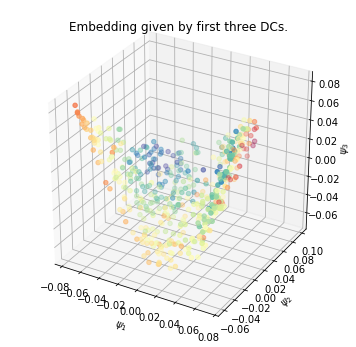

In [183]:
#from pydiffmap.visualization import embedding_plot, data_plot

figure(figsize=[20,20])
embedding_plot(mydmap,dim=3,d1=1,d2=2,d3=3, scatter_kwargs = {'c': dmap[:,4], 'cmap': 'Spectral'})
#data_plot(mydmap, dim=3, scatter_kwargs = {'cmap': 'Spectral'})

plt.show()

In [308]:
A=np.zeros([L,L])
for i in range(L):
    for j in range(L):
        w=exp(-dist2(new_Reps[i],new_Reps[j])/sigma2)
        A[i,j]=w * Reps_count[i]*Reps_count[j]

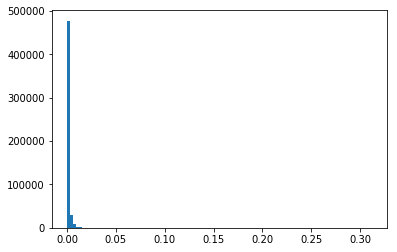

In [309]:
D=sum(A,axis=0)
D2=diag(1/sqrt(D))

NA=np.dot(D2,np.dot(A,D2))

w,v = np.linalg.eig(NA)
hist(NA.flatten(),bins=100);

eig no   0 eigval=1.000


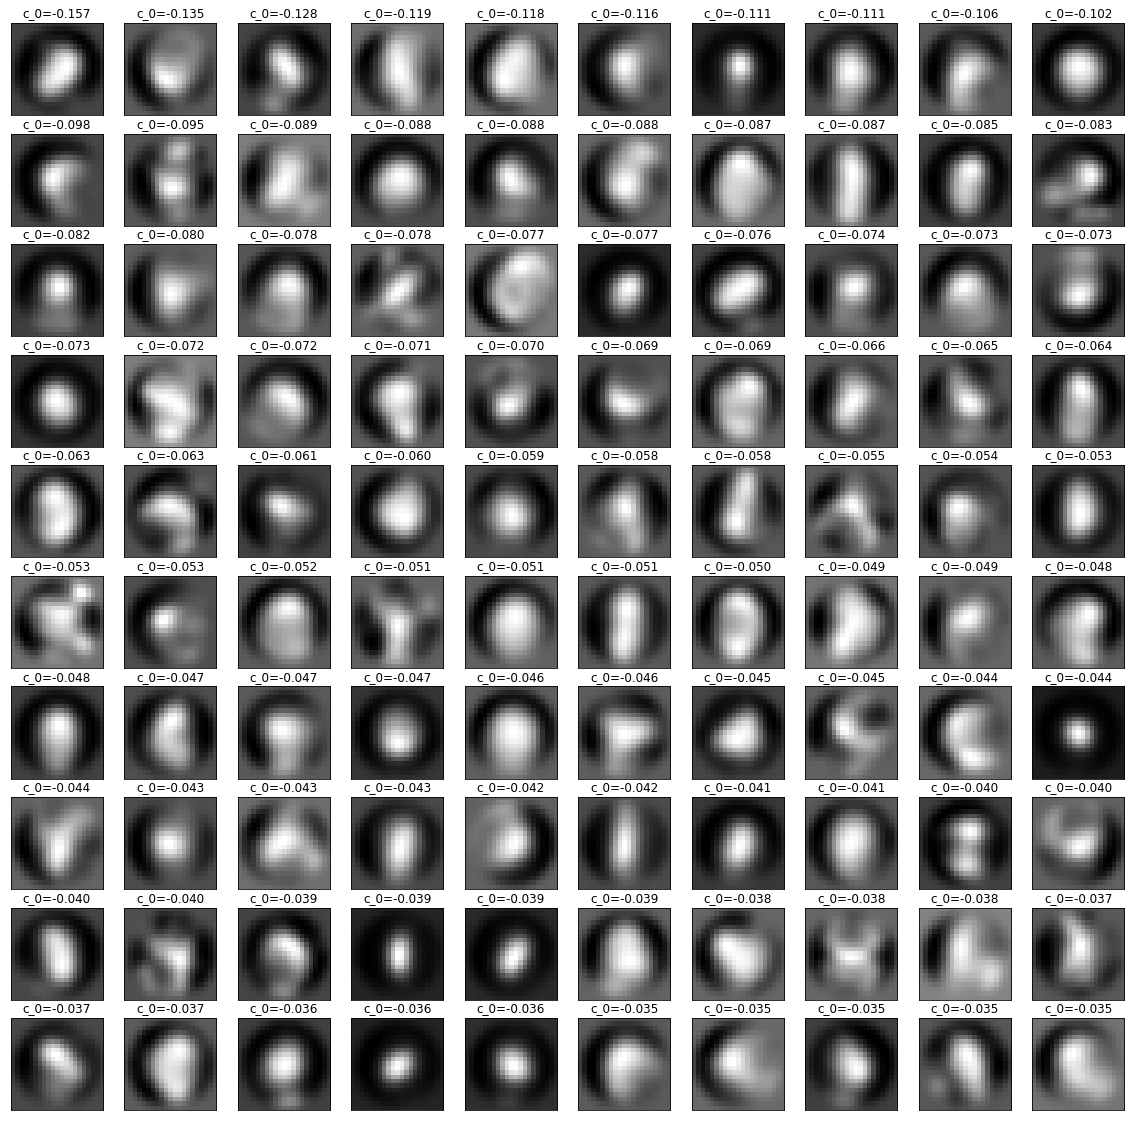

In [310]:
i=0
print('eig no %3d eigval=%5.3f'%(i,w[i]))
sorted_v=sort(v[i,:])
order=argsort(v[i,:])
plot_patches(Reps_mat[order],h=10,w=10,_titles=['c_%1d=%6.3f'%(i,x) for x in sorted_v])

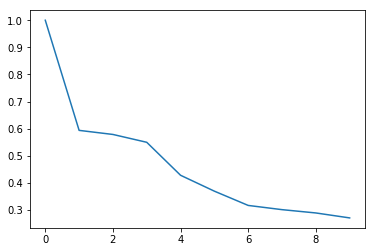

In [311]:
plot(w[:10])

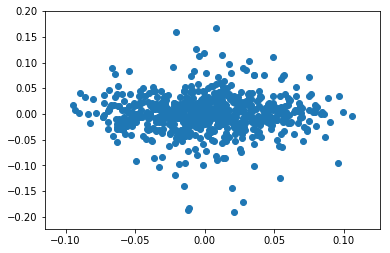

In [358]:
scatter(v[1,:],v[2,:])

array([ 0.0684984 , -0.09683269,  0.11339218, -0.02815852,  0.01356517,
        0.09702805, -0.00497052, -0.07564519, -0.00303605,  0.05598154,
       -0.02534961, -0.03255552,  0.25791296, -0.0872418 , -0.15506584,
        0.07946524,  0.11814611,  0.15164217,  0.23466678,  0.13819341,
       -0.14399507,  0.06415621,  0.07988999, -0.12789215,  0.08951426,
        0.15532145,  0.07016862,  0.15460653, -0.08454734, -0.14527753,
       -0.06276835,  0.1593729 , -0.13350627, -0.22839049,  0.01349753,
        0.23846752,  0.00080144,  0.20678977,  0.11093939,  0.12488391,
        0.01444126, -0.02112139,  0.05719365,  0.06418349, -0.223191  ,
       -0.0173864 ,  0.23103086,  0.28240511, -0.01096971,  0.01018806,
        0.02284379,  0.10457885, -0.05902885, -0.03521811, -0.006584  ,
        0.09166308,  0.0113964 , -0.00891202, -0.01769475, -0.01585222,
        0.03784947,  0.12000808,  0.07827504, -0.0363255 ,  0.02059863,
        0.21839337, -0.03755787, -0.00354101, -0.02926716, -0.01

In [185]:
v[2,:]

array([ 2.76030401e-02, -9.99369815e-01,  1.86132817e-02, -1.09338415e-02,
        1.96145234e-03, -2.14331499e-03, -8.98918520e-04,  1.85929501e-03,
        1.50086424e-03,  6.09601482e-04,  2.05811280e-03, -8.29983576e-04,
       -2.32679127e-03, -7.05417265e-04,  5.70638293e-05,  3.19153459e-04,
        2.21861093e-04, -1.49317035e-04,  3.95528026e-04, -5.57342638e-04,
       -1.30430651e-03, -4.68911652e-04, -1.96314600e-04, -6.01913609e-04,
       -1.81860647e-04, -1.19399305e-03, -6.41843880e-05, -1.20281315e-03])